# Boilerplate

In [3]:
%load_ext autoreload
%autoreload

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
import json
import optuna

from IPython.display import display
from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def f():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
def nf():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 4)
nf()
import warnings
warnings.filterwarnings('ignore')

def dp(df, r = 5, c = None):
    from IPython.display import display
    with pd.option_context('display.max_rows', 4, 'display.max_columns', None):
        display(df)

def fg(w = 6, h = 4, dpi = 120):
    plt.rcParams['figure.figsize'] = (w,h)
    plt.rcParams['figure.dpi'] = dpi
fg()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from libs.pipeline import Pipe
import lightgbm as lgb

In [6]:
df = pd.read_csv("data/UCI_Credit_Card.csv")

df.columns = df.columns.str.lower()

df = df.drop('id', axis = 1)

df = df.rename(columns = {'default.payment.next.month':'target'})

df.to_parquet('data/df_to_feature_selection.parquet', index = False)

In [7]:
for i in range(3,12,1):
    clf = lgb.LGBMClassifier(max_depth = i)
    ma = Pipe(df = df, model = clf, target_var = 'target')
    print(i)
    ma.popin.scores
    ma.oos.scores
    ma.metrics()

3


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.7,0.37,0.49,0.81,0.62


,accuracy,precision,recall,f1,auc,gini
0,0.83,0.67,0.37,0.48,0.78,0.56


4


,accuracy,precision,recall,f1,auc,gini
0,0.83,0.72,0.39,0.51,0.82,0.64


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.68,0.36,0.47,0.79,0.58


5


,accuracy,precision,recall,f1,auc,gini
0,0.84,0.75,0.41,0.53,0.85,0.7


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.66,0.36,0.47,0.78,0.56


6


,accuracy,precision,recall,f1,auc,gini
0,0.84,0.76,0.43,0.55,0.87,0.74


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.67,0.38,0.49,0.78,0.56


7


,accuracy,precision,recall,f1,auc,gini
0,0.84,0.76,0.44,0.56,0.87,0.74


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.65,0.37,0.48,0.78,0.56


8


,accuracy,precision,recall,f1,auc,gini
0,0.85,0.77,0.43,0.55,0.88,0.76


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.69,0.37,0.48,0.78,0.56


9


,accuracy,precision,recall,f1,auc,gini
0,0.85,0.77,0.44,0.56,0.88,0.76


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.66,0.36,0.47,0.78,0.56


10


,accuracy,precision,recall,f1,auc,gini
0,0.85,0.77,0.44,0.56,0.88,0.76


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.67,0.36,0.47,0.77,0.54


11


,accuracy,precision,recall,f1,auc,gini
0,0.85,0.77,0.42,0.55,0.89,0.78


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.69,0.36,0.47,0.78,0.56


In [8]:
init = 3
end = 13
for i in range(init,end,1):
    clf = lgb.LGBMClassifier(max_depth = i)
    ma = Pipe(df = df, model = clf, target_var = 'target')
    oos = ma.oos.scores
    if i == init:
        dfall = oos
        dfover = ma.overfitting
    else:
        dfall = pd.concat([dfall, oos], axis = 0)
        dfover = pd.concat([dfover, ma.overfitting], axis = 0)

In [9]:
dfall['max_depth'] = range(init, end, 1)
dfover['max_depth'] = range(init, end, 1)

In [10]:
plot = pd.melt(dfall, 
                value_vars = ['accuracy','precision','recall','f1','auc','gini'], 
                id_vars = 'max_depth')
over = pd.melt(dfover, 
                value_vars = ['accuracy','precision','recall','f1','auc','gini'], 
                id_vars = 'max_depth')

<AxesSubplot:xlabel='max_depth', ylabel='value'>

Text(0.5, 1.0, 'Diferença entre training e out of sample as max_depths increases in size')

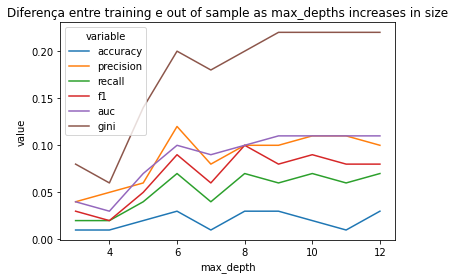

In [11]:
sns.lineplot(x = 'max_depth', 
             y = 'value', 
             hue = 'variable', 
             data = over)
plt.title('Diferença entre training e out of sample as max_depths increases in size')
plt.show()

In [12]:
popin = ma.popin.scores
oos = ma.oos.scores

In [13]:
baseparams = ma.model.get_params()

In [14]:
baseparams

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# Optuna

In [15]:
# split    
from sklearn.model_selection import train_test_split
def split(df, target_var:str, test_size:float=0.3):

    X = df.drop(target_var, axis = 1)
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = test_size,
                                                        random_state = 42)
    return X_train, X_test, y_train, y_test

In [16]:
clf = lgb.LGBMClassifier(max_depth = 6)
ma = Pipe(df = df, model = clf, target_var = 'target')
ma.popin.scores
ma.oos.scores
ma.metrics()
ma.overfitting

,accuracy,precision,recall,f1,auc,gini
0,0.84,0.75,0.42,0.54,0.87,0.74


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.69,0.37,0.48,0.78,0.56


,accuracy,precision,recall,f1,auc,gini
0,0.02,0.06,0.05,0.06,0.09,0.18


In [17]:
from libs.tuning import Tuning

In [18]:
tuning = Tuning(df,
                target_var = 'target', 
                n_trials = 30,
                chosen_optimization='f1_score')

[I 2023-02-20 09:47:26,408] A new study created in memory with name: no-name-de3876d3-13b6-4b03-b753-198e5fa99465


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:26,995] Trial 0 finished with value: 0.36 and parameters: {'boosting': 'dart', 'drop_rate': 0.245, 'extra_trees': True, 'device_type': 'cpu', 'colsample_bytree': 1.1, 'n_estimators': 150, 'learning_rate': 0.04, 'num_leaves': 30, 'max_depth': 5, 'min_gain_to_split': 0.059000000000000004, 'min_data_in_leaf': 30, 'min_child_weight': 0.00041000000000000005, 'lambda_l1': 50, 'lambda_l2': 15, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'feature_fraction_bynode': 0.55, 'pos_bagging_fraction': 0.65}. Best is trial 0 with value: 0.36.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.2 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:27,560] Trial 1 finished with value: 0.48 and parameters: {'boosting': 'dart', 'drop_rate': 0.335, 'extra_trees': True, 'device_type': 'cpu', 'colsample_bytree': 1.2, 'n_estimators': 170, 'learning_rate': 0.2, 'num_leaves': 30, 'max_depth': 3, 'min_gain_to_split': 0.020999999999999998, 'min_data_in_leaf': 120, 'min_child_weight': 0.0006100000000000001, 'lambda_l1': 100, 'lambda_l2': 90, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2, 'feature_fraction_bynode': 0.45, 'pos_bagging_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.48.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:28,243] Trial 2 finished with value: 0.36 and parameters: {'boosting': 'dart', 'drop_rate': 0.5, 'extra_trees': True, 'device_type': 'cpu', 'colsample_bytree': 1.1, 'n_estimators': 120, 'learning_rate': 0.03, 'num_leaves': 30, 'max_depth': 5, 'min_gain_to_split': 0.069, 'min_data_in_leaf': 110, 'min_child_weight': 0.0006100000000000001, 'lambda_l1': 60, 'lambda_l2': 15, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.5, 'feature_fraction_bynode': 0.7, 'pos_bagging_fraction': 0.7}. Best is trial 1 with value: 0.48.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:28,627] Trial 3 finished with value: 0.41 and parameters: {'boosting': 'dart', 'drop_rate': 0.12000000000000001, 'extra_trees': True, 'device_type': 'cpu', 'colsample_bytree': 1.0, 'n_estimators': 140, 'learning_rate': 0.19, 'num_leaves': 35, 'max_depth': 5, 'min_gain_to_split': 0.09999999999999999, 'min_data_in_leaf': 150, 'min_child_weight': 0.00051, 'lambda_l1': 15, 'lambda_l2': 20, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 16, 'feature_fraction': 0.30000000000000004, 'feature_fraction_bynode': 0.55, 'pos_bagging_fraction': 0.55}. Best is trial 1 with value: 0.48.
[I 2023-02-20 09:47:28,831] Trial 4 finished with value: 0.52 and parameters: {'boosting': 'dart', 'drop_rate': 0.12000000000000001, 'extra_trees': False, 'device_type': 'cpu', 'colsample_bytree': 1.1, 'n_estimators': 70, 'learning_rate': 0.18000000000000002, 'num_leaves': 5, 'max_depth': 10, 'min_gain_to_split': 0.044000000000000004, 'min_data_in_leaf': 60, 'min_child_weight': 0.00011, '

[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will 

[I 2023-02-20 09:47:29,158] Trial 5 finished with value: 0.0 and parameters: {'boosting': 'dart', 'drop_rate': 0.49, 'extra_trees': False, 'device_type': 'cpu', 'colsample_bytree': 1.5, 'n_estimators': 60, 'learning_rate': 0.14, 'num_leaves': 35, 'max_depth': 3, 'min_gain_to_split': 0.016, 'min_data_in_leaf': 110, 'min_child_weight': 0.0006100000000000001, 'lambda_l1': 65, 'lambda_l2': 10, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2, 'feature_fraction_bynode': 0.7, 'pos_bagging_fraction': 0.6000000000000001}. Best is trial 4 with value: 0.52.
[I 2023-02-20 09:47:29,199] Trial 6 pruned. Trial was pruned at iteration 1.
[I 2023-02-20 09:47:29,233] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-02-20 09:47:29,265] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-02-20 09:47:29,297] Trial 9 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.3 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:29,600] Trial 10 finished with value: 0.36 and parameters: {'boosting': 'dart', 'drop_rate': 0.22, 'extra_trees': False, 'device_type': 'cpu', 'colsample_bytree': 1.3, 'n_estimators': 60, 'learning_rate': 0.16, 'num_leaves': 5, 'max_depth': 12, 'min_gain_to_split': 0.035, 'min_data_in_leaf': 50, 'min_child_weight': 1e-05, 'lambda_l1': 10, 'lambda_l2': 50, 'bagging_fraction': 0.4, 'bagging_freq': 16, 'feature_fraction': 0.30000000000000004, 'feature_fraction_bynode': 0.4, 'pos_bagging_fraction': 0.4}. Best is trial 4 with value: 0.52.
[I 2023-02-20 09:47:29,686] Trial 11 pruned. Trial was pruned at iteration 1.
[I 2023-02-20 09:47:29,764] Trial 12 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.2 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:30,135] Trial 13 finished with value: 0.36 and parameters: {'boosting': 'dart', 'drop_rate': 0.20500000000000002, 'extra_trees': False, 'device_type': 'cpu', 'colsample_bytree': 1.4, 'n_estimators': 90, 'learning_rate': 0.16, 'num_leaves': 5, 'max_depth': 11, 'min_gain_to_split': 0.025, 'min_data_in_leaf': 130, 'min_child_weight': 0.00071, 'lambda_l1': 100, 'lambda_l2': 35, 'bagging_fraction': 0.5, 'bagging_freq': 6, 'feature_fraction': 0.30000000000000004, 'feature_fraction_bynode': 0.4, 'pos_bagging_fraction': 0.6000000000000001}. Best is trial 4 with value: 0.52.
[I 2023-02-20 09:47:30,217] Trial 14 pruned. Trial was pruned at iteration 1.
[I 2023-02-20 09:47:30,299] Trial 15 pruned. Trial was pruned at iteration 1.
[I 2023-02-20 09:47:30,378] Trial 16 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:30,459] Trial 17 pruned. Trial was pruned at iteration 1.
[I 2023-02-20 09:47:30,692] Trial 18 finished with value: 0.48 and parameters: {'boosting': 'dart', 'drop_rate': 0.175, 'extra_trees': False, 'device_type': 'cpu', 'colsample_bytree': 1.4, 'n_estimators': 50, 'learning_rate': 0.09, 'num_leaves': 10, 'max_depth': 8, 'min_gain_to_split': 0.024, 'min_data_in_leaf': 40, 'min_child_weight': 0.00051, 'lambda_l1': 20, 'lambda_l2': 85, 'bagging_fraction': 0.5, 'bagging_freq': 11, 'feature_fraction': 0.30000000000000004, 'feature_fraction_bynode': 0.4, 'pos_bagging_fraction': 0.45}. Best is trial 4 with value: 0.52.
[I 2023-02-20 09:47:30,772] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2023-02-20 09:47:30,853] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2023-02-20 09:47:30,945] Trial 21 pruned. Trial was pruned at iteration 2.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.2 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:31,036] Trial 22 pruned. Trial was pruned at iteration 2.
[I 2023-02-20 09:47:31,242] Trial 23 finished with value: 0.36 and parameters: {'boosting': 'dart', 'drop_rate': 0.17, 'extra_trees': False, 'device_type': 'cpu', 'colsample_bytree': 1.3, 'n_estimators': 50, 'learning_rate': 0.12, 'num_leaves': 5, 'max_depth': 10, 'min_gain_to_split': 0.03, 'min_data_in_leaf': 30, 'min_child_weight': 0.00051, 'lambda_l1': 0, 'lambda_l2': 65, 'bagging_fraction': 0.5, 'bagging_freq': 11, 'feature_fraction': 0.30000000000000004, 'feature_fraction_bynode': 0.45, 'pos_bagging_fraction': 0.45}. Best is trial 4 with value: 0.52.
[I 2023-02-20 09:47:31,335] Trial 24 pruned. Trial was pruned at iteration 6.
[I 2023-02-20 09:47:31,418] Trial 25 pruned. Trial was pruned at iteration 1.
[I 2023-02-20 09:47:31,497] Trial 26 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


[I 2023-02-20 09:47:31,735] Trial 27 finished with value: 0.36 and parameters: {'boosting': 'dart', 'drop_rate': 0.1, 'extra_trees': False, 'device_type': 'cpu', 'colsample_bytree': 1.3, 'n_estimators': 50, 'learning_rate': 0.09999999999999999, 'num_leaves': 25, 'max_depth': 6, 'min_gain_to_split': 0.049, 'min_data_in_leaf': 100, 'min_child_weight': 0.0006100000000000001, 'lambda_l1': 25, 'lambda_l2': 75, 'bagging_fraction': 0.4, 'bagging_freq': 6, 'feature_fraction': 0.30000000000000004, 'feature_fraction_bynode': 0.5, 'pos_bagging_fraction': 0.65}. Best is trial 4 with value: 0.52.
[I 2023-02-20 09:47:31,817] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2023-02-20 09:47:31,900] Trial 29 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] Unknown parameter: ming_gain_to_split
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


In [19]:
bestparams = tuning.study.best_params

In [20]:
bestparams

{'boosting': 'dart',
 'drop_rate': 0.12000000000000001,
 'extra_trees': False,
 'device_type': 'cpu',
 'colsample_bytree': 1.1,
 'n_estimators': 70,
 'learning_rate': 0.18000000000000002,
 'num_leaves': 5,
 'max_depth': 10,
 'min_gain_to_split': 0.044000000000000004,
 'min_data_in_leaf': 60,
 'min_child_weight': 0.00011,
 'lambda_l1': 35,
 'lambda_l2': 35,
 'bagging_fraction': 0.4,
 'bagging_freq': 11,
 'feature_fraction': 0.30000000000000004,
 'feature_fraction_bynode': 0.45,
 'pos_bagging_fraction': 0.55}

In [25]:
baseparams = ma.model.get_params()

In [26]:
best = lgb.LGBMClassifier().set_params(**bestparams)

mbest = Pipe(df, target_var = 'target', model = best)

mbest.popin.scores

mbest.oos.scores

,accuracy,precision,recall,f1,auc,gini
0,0.82,0.66,0.41,0.51,0.79,0.58


,accuracy,precision,recall,f1,auc,gini
0,0.82,0.64,0.4,0.49,0.78,0.56


In [ ]:
base = lgb.LGBMClassifier().set_params(**baseparams)

mbase = Pipe(df, target_var = 'target', model = base)

mbase.popin.scores

mbase.oos.scores

In [ ]:
optuna.visualization.plot_param_importances(tuning.study)

In [ ]:
optuna.visualization.plot_optimization_history(tuning.study)

In [ ]:
optuna.visualization.plot_intermediate_values(tuning.study)

In [ ]:
optuna.visualization.plot_slice(tuning.study)

In [ ]:
optuna.visualization.plot_contour(tuning.study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(tuning.study)